# Analisi del Modello di Ekman con Dati Oceanografici
Ingrid Pelingu 
### Introduzione
Questo studio si propone di analizzare l’applicabilità del modello di Ekman alle correnti marine, utilizzando i dati raccolti dalla boa oceanografica VIDA. Il modello di Ekman descrive la dinamica delle correnti superficiali soggette allo stress del vento e alla forza di Coriolis.

L’analisi si concentra sull’evento di bora osservato tra il 7 gennaio e il 9 gennaio 2024, considerando il range di profondità compreso tra 2 e 20 metri dal fondale. Questo intervallo temporale e spaziale è stato scelto in quanto caratterizzato da condizioni di vento quasi costanti in termini di direzione e intensità, permettendo così una migliore approssimazione del modello di Ekman.

L’obiettivo è valutare la validità del modello confrontando le previsioni teoriche con i dati osservati, stimando i parametri chiave attraverso un approccio Bayesiano basato su campionamento MCMC (Markov Chain Monte Carlo) implementato con emcee.

In [67]:
#importo delle librerie 
import pandas as pd
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner
from scipy.optimize import minimize
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#### Preparazione e Analisi dei Dati

I dati utilizzati per l'analisi sono stati estratti dalla piattaforma Oceanographic Data and Measurements - Buoy 2 in formato excel per essere poi analizzati con il pacchetto pandas. 

In [68]:
# 1️⃣ Caricare il file Excel
file_path = r"C:\Users\ingri\OneDrive\Desktop\cartella\vento.xlsx"  
df_vento = pd.read_excel(file_path, skiprows=1)
# 2️⃣ Convertire la colonna "Date and time" in formato datetime
df_vento["Date and time"] = pd.to_datetime(df_vento["Date and time"])


## 1. Visualizzazione della Spirale di ekman con i dati osservati
#### Filtraggio dei dati:
Per garantire uniformità nelle condizioni atmosferiche, è stato applicato un filtro che seleziona i dati entro una deviazione standard dalla media di intensità e direzione del vento. L’analisi si concentra sull’evento di bora verificatosi tra le 00:00 del 7 gennaio e le 23:59 del 9 gennaio 2024, considerando le profondità comprese tra 2 e 20 metri dal fondale marino (22 m).

In [69]:
# 3️⃣ Filtrare i dati entro ±1 deviazione standard dalla media del vento
df_filtered = df_vento[
    (df_vento["Mean Wind Speed"].between(df_vento["Mean Wind Speed"].mean() - df_vento["Mean Wind Speed"].std(), 
                                         df_vento["Mean Wind Speed"].mean() + df_vento["Mean Wind Speed"].std())) &
    (df_vento["Mean Wind Direction"].between(df_vento["Mean Wind Direction"].mean() - df_vento["Mean Wind Direction"].std(), 
                                             df_vento["Mean Wind Direction"].mean() + df_vento["Mean Wind Direction"].std()))
]

# 4️⃣ Calcolare la media delle componenti di corrente per ogni profondità (2m-20m)
depths = np.arange(2, 21)
current_e_means = [df_filtered[f"CurrentE ({d} m)"].mean() for d in depths]
current_e_std = [df_filtered[f"CurrentE ({d} m)"].std() for d in depths]

current_n_means = [df_filtered[f"CurrentN ({d} m)"].mean() for d in depths]
current_n_std = [df_filtered[f"CurrentN ({d} m)"].std() for d in depths]


#### Visualizzazione e analisi dei risultati:

L'analisi ha evidenziato l'andamento medio delle correnti in funzione della profondità, confermando una struttura simile alla spirale di Ekman. Dai valori ottenuti delle correnti e dal grafico si può vedere che la componente est (U) della corrente mostra un progressivo aumento con il diminuire della profondità. Un dato particolarmente significativo è il valore di -11.92 m/s registrato a circa 2 metri dalla superficie, rappresentando un'intensità della corrente compatibile con l'effetto diretto del vento sulla colonna d'acqua. Questo fenomeno indica un'intensificazione del flusso verso ovest, coerente con la teoria dell'Ekman Transport.

Analogamente, la componente nord (V) della corrente subisce un aumento con il decrescere della profondità, fino a diventare circa -3 m/s negli strati più superficiali. Questo comportamento riflette la tipica rotazione della spirale di Ekman, influenzata dalla forza di Coriolis. 
In generale, in molti casi oceanografici, la corrente superficiale tende a essere più veloce rispetto a quella a profondità maggiori, poiché la frizione con l'atmosfera, causata dal vento, ha un impatto maggiore sulla parte superiore dell'acqua. La velocità della corrente diminuisce con la profondità a causa della maggiore resistenza al movimento dell'acqua più profonda, che è meno influenzata dalle forze superficiali.

Inoltre, sono stati stampati i valori delle componenti est e nord della corrente ottenuti dopo l’applicazione del filtro, insieme alle relative deviazioni standard. Le elevate deviazioni standard osservate suggeriscono una significativa variabilità delle misurazioni, probabilmente dovuta a fenomeni di turbolenza o a variazioni locali nelle condizioni oceanografiche. 


Indice | Corrente (Est) | Corrente (Nord) | corrente std E | corrente std N
---------------------------------------------------------------------------
  0    |     -2.554     |     2.500      |     9.004      |     7.175     
  1    |     -2.246     |     2.758      |     9.011      |     7.154     
  2    |     -2.772     |     2.317      |     9.605      |     7.085     
  3    |     -2.826     |     2.483      |     9.522      |     7.390     
  4    |     -3.090     |     2.987      |     9.402      |     7.448     
  5    |     -3.226     |     2.401      |     9.689      |     7.257     
  6    |     -3.483     |     2.229      |     10.019     |     7.268     
  7    |     -3.338     |     1.999      |     10.126     |     7.447     
  8    |     -3.710     |     1.783      |     10.170     |     7.723     
  9    |     -3.443     |     2.484      |     9.968      |     7.371     
  10   |     -4.220     |     1.865      |     9.800      |     7.260     
  11   |     -4.412   

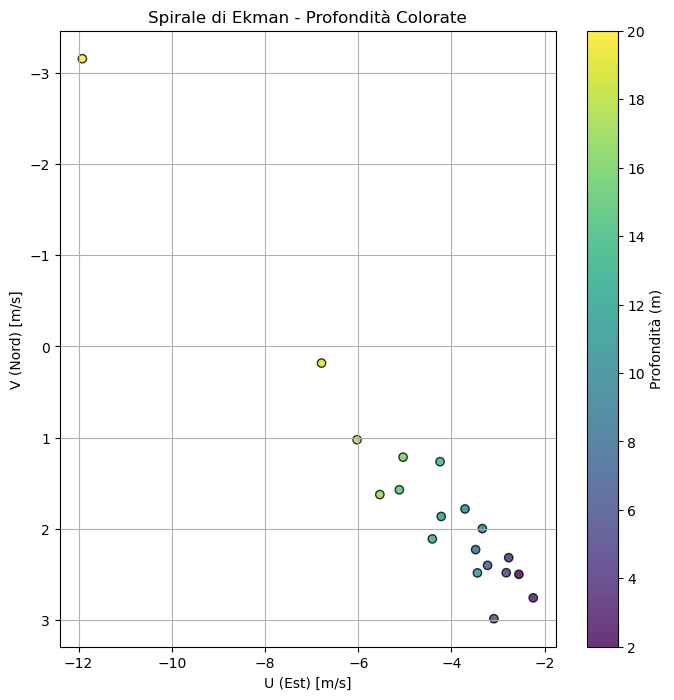

In [70]:
# Stampa dell'intestazione
print("\nIndice | Corrente (Est) | Corrente (Nord) | corrente std E | corrente std N")
print("-" * 75)

# Stampa dei dati con formattazione
for i in range(len(current_e_means)):
    print(f"{i:^6} | {current_e_means[i]:^14.3f} | {current_n_means[i]:^14.3f} | {current_e_std[i]:^14.3f} | {current_n_std[i]:^14.3f}")

# Visualizzazione della spirale di Ekman con colori della profondità
plt.figure(figsize=(8, 8))
sc = plt.scatter(current_e_means, current_n_means, c=depths, cmap="viridis", edgecolors='k', alpha=0.8)
plt.xlabel("U (Est) [m/s]")
plt.ylabel("V (Nord) [m/s]")
plt.gca().invert_yaxis()
plt.title("Spirale di Ekman - Profondità Colorate")
plt.colorbar(sc, label="Profondità (m)")
plt.grid()
plt.show()


## 2. Implementazione del Modello di Ekman 
Il modello di Ekman descrive la variazione della velocità delle correnti marine in funzione della profondità a causa dell'interazione tra il vento superficiale e la forza di Coriolis. In questa sezione, si applicano le equazioni del modello per valutare la spirale di Ekman a partire dai parametri caratteristici.

### Parametri Considerati
Per l'implementazione del modello vengono utilizzati una serie di parametri fisici fondamentali, definiti all'inizio del calcolo. Tali parametri includono:
- **τ**: stress del vento
- **d**: profondità dello strato di Ekman
- **Φ**: angolo di fase
- **ug, vg**: velocità geostrofiche
- **f**: parametro di Coriolis
- **Omega**: velocità angolare della terra
- **d**: spessore dello strato di ekman
- **$\boldsymbol{\phi}$**: latitudine espressa in radianti  
- **$\boldsymbol{\rho}$**: densità dell'acqua


Sono stati utilizzati valori caratteristici per questi parametri per ottenere la struttura della spirale di Ekman, ovvero:
- **tau** = -8 
- **d** = 16 
- **phi** = -0.55 rad
- **ug** = -1
- **vg** = -6

Successivamente, vengono definite le equazioni che descrivono le componenti est (u) e nord (v) della velocità in funzione della profondità :

\begin{equation}
    u(z) = ug + \sqrt{\frac{2}{\rho \cdot f \cdot d}} \cdot e^{z/d} \cdot \left( T_x \cdot \cos\left(\frac{z}{d} - \phi\right) - T_y \cdot \sin\left(\frac{z}{d} - \phi\right) \right)
\end{equation}

\begin{equation}
    v(z) = vg + \sqrt{\frac{2}{\rho \cdot f \cdot d}} \cdot e^{z/d} \cdot \left( T_x \cdot \sin\left(\frac{z}{d} - \phi\right) + T_y \cdot \cos\left(\frac{z}{d} - \phi\right) \right)
\end{equation}

dove $T_x$ e $T_y$ indicano le componenti dello stress superficiale del vento lungo le direzioni est e nord, rispettivamente:
$$
T_x = \tau \cos(\Theta)
$$

$$
T_y = \tau \sin(\Theta)
$$
con $\Theta$ la direzione del vento data dalla media dei valori filtrati dei dati relativi alla direzione del vento.  


In [71]:
# Definizione dei parametri fisici
omega_terra = 7.2921e-5  # Velocità angolare della Terra (rad/s)
latitudine = np.radians(45.55)  # Latitudine in radianti
coriolis = 2 * omega_terra * np.sin(latitudine)  # Parametro di Coriolis
d_acqua = 1025  # Densità dell'acqua marina (kg/m^3)

p_ekman = 16  # Profondità dello strato di Ekman (m)
v_geo_E, v_geo_N = -1, -6  # Componenti della velocità geostrofica
tau_vento = -8  # Stress del vento (N/m^2) - da verificare con i dati
phi_corrente_vento = -0.55  # Angolo tra corrente superficiale e vento

# Calcolo della direzione media del vento
phi_vento = np.radians(df_filtered["Mean Wind Direction"].mean())  # Converti in radianti 

# Calcolo delle componenti dello stress del vento
tau_E = tau_vento * np.cos(phi_vento)
tau_N = tau_vento * np.sin(phi_vento)

# Definizione della profondità negativa (da -2m a -20m)
profondita = np.linspace(-20, -2, 19)

# Calcolo delle componenti della velocità secondo il modello di Ekman
corrente_E = (v_geo_E + np.sqrt(2) / (d_acqua * coriolis * p_ekman) *
              np.exp(profondita / p_ekman) * 
              (tau_E * np.cos(profondita / p_ekman - phi_corrente_vento) - 
               tau_N * np.sin(profondita / p_ekman - phi_corrente_vento)))

corrente_N = (v_geo_N + np.sqrt(2) / (d_acqua * coriolis * p_ekman) *
              np.exp(profondita / p_ekman) * 
              (tau_E * np.sin(profondita / p_ekman - phi_corrente_vento) + 
               tau_N * np.cos(profondita / p_ekman - phi_corrente_vento)))

#### Visualizzazione e analisi dei risultati:
L'analisi su dati oceanografici, che includono la velocità del flusso nelle direzioni Est(U) e Nord(V) a diverse profondità, sono stati elaborati e visualizzati in un grafico scatter, dove la velocità dell'acqua segue un andamento a spirale, con variazioni progressive nella direzione del flusso all'aumentare della profondità. I punti di colore giallo, rappresentanti profondità minori, mostrano velocità più elevate e direzioni prossime alla direzione del vento. Con l'aumento della profondità (colori più scuri), la velocità diminuisce e la direzione ruota, come previsto dalla teoria di Ekman. Il fenomeno è coerente con la teoria della spirale di Ekman, che prevede un'inversione della direzione del flusso nelle profondità maggiori a causa dell'attrito viscoso e dell'effetto di Coriolis.





Indice | Corrente (Est) | Corrente (Nord) 
-----------------------------------
  0    |     -2.816     |     -6.553    
  1    |     -2.893     |     -6.708    
  2    |     -2.964     |     -6.878    
  3    |     -3.028     |     -7.064    
  4    |     -3.084     |     -7.265    
  5    |     -3.130     |     -7.482    
  6    |     -3.164     |     -7.716    
  7    |     -3.185     |     -7.967    
  8    |     -3.191     |     -8.235    
  9    |     -3.179     |     -8.521    
  10   |     -3.147     |     -8.823    
  11   |     -3.094     |     -9.142    
  12   |     -3.015     |     -9.477    
  13   |     -2.910     |     -9.828    
  14   |     -2.775     |    -10.194    
  15   |     -2.607     |    -10.574    
  16   |     -2.403     |    -10.966    
  17   |     -2.160     |    -11.369    
  18   |     -1.876     |    -11.782    


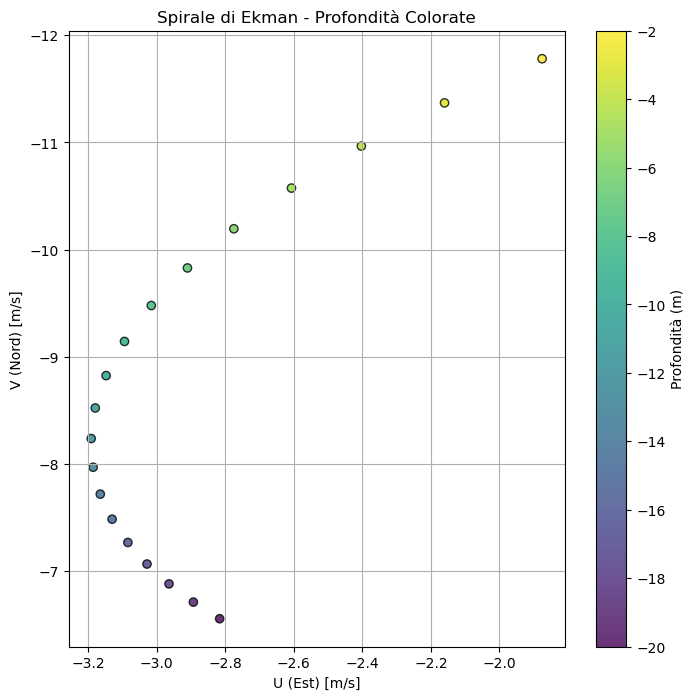

In [72]:
# Stampa dell'intestazione
print("\nIndice | Corrente (Est) | Corrente (Nord) ")
print("-" * 35)

# Stampa dei dati con formattazione
for i in range(len(corrente_E)):
    print(f"{i:^6} | {corrente_E[i]:^14.3f} | {corrente_N[i]:^14.3f}")

# Visualizzazione della spirale di Ekman con colori della profondità
plt.figure(figsize=(8, 8))
norm = mcolors.Normalize(vmin=-20, vmax=-2)
sc = plt.scatter(corrente_E, corrente_N, c=profondita, cmap="viridis", norm=norm, edgecolors='k', alpha=0.8)
plt.xlabel("U (Est) [m/s]")
plt.ylabel("V (Nord) [m/s]")
plt.gca().invert_yaxis()
plt.title("Spirale di Ekman - Profondità Colorate")
plt.colorbar(sc, label="Profondità (m)")
plt.grid()
plt.show()


##### Vsualizzazione del grafico in 3D
Il grafico 3D mostra:

- La Spirale di Ekman: La linea tratteggiata rossa rappresenta il moto della corrente oceanica in funzione della profondità
- Le frecce lungo la spirale mostrano la direzione della corrente a diversi livelli di profondità, le quali sono colorate secondo la profondità per facilitare la lettura.
- Le frecce dalla profondità all'origine indicano l’intensità della corrente a diverse profondità e la loro lunghezza è proporzionale alla velocità del flusso. Si osserva che le correnti superficiali sono più intense e diminuiscono con la profondità.
- La proiezione XY della spirale mostra il percorso della corrente senza tener conto della profondità. Si può vedere come la corrente cambia direzione man mano che si scende.

Il grafico conferma il modello teorico della spirale di Ekman:

- Superficie: La corrente è massima e si muove in una direzione specifica.
- Profondità crescente: la velocità della corrente diminuisce con la profondità e devia a destra (emisfero nord) a causa dell’effetto Coriolis.
- Effetto Coriolis: Responsabile della rotazione del flusso.

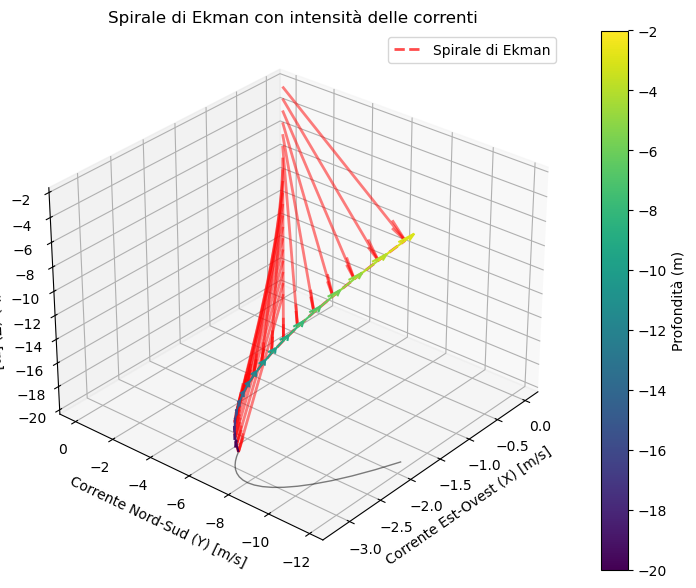

In [73]:
# Normalizzazione della profondità per associare un colore ad ogni valore di profondità
norm = colors.Normalize(vmin=np.min(profondita), vmax=np.max(profondita))
cmap = cm.viridis  # Utilizziamo la colormap 'viridis' che va dal viola al giallo
colors_array = cmap(norm(profondita))  # Assegna un colore in base ai valori di profondità

# Creazione della figura per il grafico 3D
fig = plt.figure(figsize=(10, 7))  # Impostazione delle dimensioni della figura
ax = fig.add_subplot(111, projection='3d')  # Creazione dell'asse 3D

# **Tracciamento della Spirale di Ekman**
# Tracciamo la spirale di Ekman come una linea tratteggiata rossa, che rappresenta la traiettoria delle correnti in funzione della profondità
ax.plot(corrente_E, corrente_N, profondita, 'r--', alpha=0.7, linewidth=2, label="Spirale di Ekman")

# **Aggiunta delle frecce lungo la spirale per rappresentare la direzione del flusso**
step = 1  # Intervallo tra le frecce
# Usando 'np.diff', calcoliamo la variazione tra i punti adiacenti per ottenere la direzione della corrente
ax.quiver(
    corrente_E[::step], corrente_N[::step], profondita[::step],  # Punti di partenza delle frecce
    np.diff(corrente_E, append=corrente_E[-1])[::step],  # Variazione in X (Est-Ovest)
    np.diff(corrente_N, append=corrente_N[-1])[::step],  # Variazione in Y (Nord-Sud)
    np.diff(profondita, append=profondita[-1])[::step],  # Variazione in Z (profondità)
    color=colors_array[::step],  # Colori delle frecce in base alla profondità
    length=1.5,  # Lunghezza delle frecce
    normalize=True  # Normalizza le frecce per una visualizzazione uniforme
)

# **Aggiunta delle frecce per rappresentare l'intensità delle correnti**
# Per ogni profondità, calcoliamo la velocità della corrente come il modulo del vettore velocità
for i in range(len(profondita)):
    velocita_corrente = np.sqrt(corrente_E[i]**2 + corrente_N[i]**2)  # Calcolo del modulo della velocità
    ax.quiver(
        0, 0, profondita[i],  # Punto di origine delle frecce (all'origine X=0, Y=0)
        corrente_E[i], corrente_N[i], 0,  # Componente della velocità in X e Y
        color='r', alpha=0.5, linewidth=2, arrow_length_ratio=0.1  # Frecce rosse con trasparenza e rapporto di lunghezza dell'arco
    )

# **Proiezione della spirale nel piano XY**
# Aggiungiamo una proiezione della spirale sul piano orizzontale XY per osservare la sua evoluzione senza considerare la profondità
ax.plot(corrente_E, corrente_N, np.full_like(profondita, profondita.min()), 'k-', alpha=0.5, linewidth=1)

# **Impostazione degli assi e della visualizzazione**
ax.set_xlabel("Corrente Est-Ovest (X) [m/s]")  # Etichetta per l'asse X
ax.set_ylabel("Corrente Nord-Sud (Y) [m/s]")  # Etichetta per l'asse Y
ax.set_zlabel("Profondità (Z) [m]")  # Etichetta per l'asse Z
ax.set_title("Spirale di Ekman con intensità delle correnti")  # Titolo del grafico

# **Angolazione ottimale per la vista 3D**
# Impostiamo l'angolo di elevazione e azimutale per una visualizzazione chiara della spirale e delle frecce
ax.view_init(elev=30, azim=220)

# **Aggiunta della barra dei colori per rappresentare la profondità**
# Creiamo una mappa di colori scalare per rappresentare la profondità sul grafico
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # L'array deve essere vuoto per generare il colormap
fig.colorbar(sm, ax=ax, label="Profondità (m)")  # Aggiungiamo la barra dei colori

# **Visualizzazione della legenda**
plt.legend()  # Aggiunge la legenda per spiegare la spirale di Ekman

# **Mostriamo il grafico**
plt.show()  # Visualizza il grafico generato

## 3. Algoritmo emcee
Il modello di Ekman descrive la distribuzione verticale delle correnti marine sotto l'effetto del vento e della forza di Coriolis. L'obiettivo di questa analisi è stimare i parametri del modello utilizzando dati osservati di vento e corrente e confrontarli con le previsioni teoriche.
Per ottenere una stima ottimale dei parametri, utilizziamo un approccio Bayesiano basato su massimizzazione della verosimiglianza (log-likelihood) e successivamente campionamento MCMC (Markov Chain Monte Carlo) per ottenere distribuzioni di probabilità a posteriori. La scelta di σ=0.5 m/s deriva dall'assunzione che l'errore di misura della velocità della corrente segua una distribuzione gaussiana con deviazione standard di 0.5 m/s. Questo valore rappresenta l'incertezza associata alle misurazioni e influisce direttamente sulla funzione di verosimiglianza.

In [74]:
# Parametri fisici
Omega = 7.2921e-5  # Velocità angolare della Terra (rad/s)
phi = np.radians(45.55)  # Latitudine in radianti
f = 2 * Omega * np.sin(phi)  # Parametro di Coriolis
rho = 1025  # Densità dell'acqua marina (kg/m^3)

# Definizione della profondità negativa (da -2m a -20m) rispetto al fondale che si trova a 22m
z = np.linspace(-20, -2, 19)

# Dati osservati delle correnti
u_obs = np.array(current_e_means)
v_obs = np.array(current_n_means)

# Media della direzione del vento (correggendo il nome della colonna)
wind_direction_mean = np.radians(df_filtered["Mean Wind Direction"].mean())  # Converti in radianti

# Errore di misura
sigma = 0.5  # m/s 


#### Modello teorico di Ekman
Il modello teorico di Ekman descrive la variazione della velocità della corrente con la profondità sotto l'influenza della forza di Coriolis. L'espressione delle componenti della corrente in funzione della profondità z sono date dalle due equazioni **u(z)** e **v(z)** scritte precedentemente. 

In [75]:
# Modello teorico di Ekman
def ekman_model(z, tau, d, phi_angle, U_g, V_g):
    theta = wind_direction_mean  # Ora è in radianti
    Tx = tau * np.cos(theta)
    Ty = tau * np.sin(theta)
    
    u = U_g + np.sqrt(2) / (rho * f * d) * np.exp(z / d) * (Tx * np.cos(z / d - phi_angle) - Ty * np.sin(z / d - phi_angle))
    v = V_g + np.sqrt(2) / (rho * f * d) * np.exp(z / d) * (Tx * np.sin(z / d - phi_angle) + Ty * np.cos(z / d - phi_angle))
    
    return u, v


### Stima dei Parametri

Per stimare i parametri , utilizziamo un approccio Bayesiano basato sulla massimizzazione della verosimiglianza e sull'analisi MCMC:

#### Funzione di Verosimiglianza

Se assumiamo che le osservazioni $\ u_{\text{obs}} $ e $\ v_{\text{obs}} $ abbiano errori gaussiani indipendenti con deviazione standard $\sigma = 0,5  m/s $, allora la funzione di verosimiglianza è:
\begin{equation}
\
\mathcal{L} = \prod_{i} \frac{1}{2\pi\sigma^2} \exp\left( -\frac{(u_{\text{obs},i} - u_{\text{model},i})^2 + (v_{\text{obs},i} - v_{\text{model},i})^2}{2\sigma^2} \right)
\
\end{equation}
##### Log-Verosimiglianza

Prendendo il logaritmo della verosimiglianza:
\begin{equation}
\
\log \mathcal{L} = -\frac{1}{2} \sum_{i} \left[ \frac{(u_{\text{obs},i} - u_{\text{model},i})^2 + (v_{\text{obs},i} - v_{\text{model},i})^2}{\sigma^2} \right] - N \log (2\pi\sigma^2)
\
\end{equation}
Dove \( N \) è il numero di dati osservati, che nel caso del codice è semplicemente la lunghezza di u_obs (o v_obs), cioè il numero totale di punti dati.

- $ u_{\text{obs}}$ , $v_{\text{obs}} $ sono le componenti osservate della corrente,
- $ u_{\text{mod}}$ , $v_{\text{mod}} $ sono le componenti della corrente previste dal modello,
- $ \sigma = 0.5 $ m/s è l'errore di misura assunto.

Questa funzione viene utilizzata per calcolare la probabilità di ottenere i dati osservati dati i parametri del modello.


In [76]:
# Funzione di likelihood (assumendo errore gaussiano)
def log_likelihood(theta, z, u_obs, v_obs, sigma):
    tau, d, phi_angle, U_g, V_g = theta
    u_model, v_model = ekman_model(z, tau, d, phi_angle, U_g, V_g)
    
    chi2 = np.sum(((u_obs - u_model) / sigma) ** 2) + np.sum(((v_obs - v_model) / sigma) ** 2)
    return -0.5 * chi2 - len(u_obs)*np.log((sigma**2) *(2 * np.pi))

#### Definizione della Distribuzione a Priori

Nell'implementazione del metodo MCMC, viene definita una distribuzione a priori uniforme sui parametri del modello. Questa scelta implica che ogni valore dei parametri compreso nei limiti specificati ha la stessa probabilità iniziale, mentre valori al di fuori di questi limiti hanno probabilità nulla.

La funzione prior è definita come:

$$
 P(\theta) =
 \begin{cases}
 0, & \text{se } \tau < 0, \ d > 0, \ -\pi < \phi < \pi, \ -20 < U_g < 20, \ -20 < V_g < 20 \\
 -\infty, & \text{altrimenti}
 \end{cases}
$$

Se un insieme di parametri non soddisfa questi vincoli, la funzione prior restituisce $-\infty$ , escludendo quindi quella combinazione di parametri dal campionamento.

In [77]:
# Prior uniforme
def log_prior(theta):
    tau, d, phi_angle, U_g, V_g = theta
    if  tau < 0 and  d > 0 and -np.pi < phi_angle < np.pi and -20 < U_g < 20 and -20 < V_g < 20:
        return 0.0  # Prior uniforme
    return -np.inf  # Probabilità zero fuori dai limiti

#### Funzione di Log-Posterior

La funzione log-posterior combina la probabilità a priori e la verosimiglianza per valutare la probabilità dei parametri dati i dati osservati. Essa è definita come:
$$
\log P(\theta | D) = \log P(\theta) + \log P(D | \theta)
$$
dove $\log P(\theta)$ è la prior e $\log P(D | \theta)$ è la log-verosimiglianza.
Questa funzione:

- Calcola il valore della prior tramite $\log_{prior}(\theta)$.
- Se il valore della prior è finito, aggiunge la log-verosimiglianza dei dati, calcolata tramite log_likelihood.
- Se la prior restituisce $-\infty$, allora la funzione restituisce $-\infty$, escludendo quei parametri dal campionamento.


Questa formulazione permette di ottenere una stima dei parametri che bilancia le informazioni a priori con i dati osservati, rendendo il modello coerente con le osservazioni sperimentali.

In [78]:
# Funzione log-posterior
def log_posterior(theta, z, u_obs, v_obs, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, u_obs, v_obs, sigma)

#### Ottimizzazione dei Parametri
L'algoritmo cerca di minimizzare la funzione di log-posterior negativa, cioè massimizzare la probabilità che i parametri riproducano i dati osservati.
La funzione minimize() viene inizializzata con un set plausibile di valori (initial_guess), che include lo stress del vento τ, la profondità dello strato di Ekman d, l'angolo tra la corrente e il vento Φ, e le componenti residue U_g e V_g.
Il risultato dell'ottimizzazione (soln.x) fornisce la migliore stima dei parametri secondo la funzione di log-posterior.
I valori ottimizzati vengono stampati per confronto con quelli iniziali e si osserva una variazione significativa nella profondità di Ekman d e nell'angolo Φ, indicando un miglior adattamento ai dati osservati.

In [79]:
# 🔹 Ottimizzazione con minimize()
np.random.seed(42)
nll = lambda *args: -log_posterior(*args)
initial_guess = np.array([-5, 10, 1.5, -3., 1.])  # Valori iniziali plausibili 


print("Initial guess:", initial_guess)

soln = minimize(nll, initial_guess, args=(z, u_obs, v_obs, sigma))


# 🔹 Miglior stima dai risultati dell'ottimizzazione
best_fit_params = soln.x
print("Parametri ottimizzati con minimize():", best_fit_params)

Initial guess: [-5.  10.   1.5 -3.   1. ]
Parametri ottimizzati con minimize(): [-4.09457898  6.37756816  0.16361989 -2.7724706   1.36038387]


#### Processo di Campionamento MCMC
Il processo di campionamento è stato eseguito utilizzando l'algoritmo MCMC tramite il pacchetto emcee. La procedura è stata avviata definendo 20 camminatori (nwalkers), ciascuno dei quali esplora lo spazio dei parametri in 5 dimensioni, corrispondenti ai parametri ottimizzati del modello. I camminatori sono stati inizializzati con i valori dei parametri ottenuti dal fitting preliminare, perturbati da un piccolo rumore casuale per garantire una varietà iniziale nel campionamento.

Il campionamento è stato eseguito per 20.000 iterazioni, durante le quali i camminatori esplorano lo spazio dei parametri secondo la funzione di probabilità a posteriori, che tiene conto dei dati osservati (velocità della corrente) e del modello proposto. Questo processo permette di ottenere una stima della distribuzione a posteriori dei parametri.

Successivamente, è stato calcolato il tempo di autocorrelazione per ogni camminatore. Questo valore misura la correlazione tra i campioni della catena: un tempo di autocorrelazione elevato indica che i campioni sono fortemente correlati e il processo sta esplorando lentamente lo spazio dei parametri. Un tempo di autocorrelazione ridotto, invece, suggerisce che il campionamento è più efficiente e i campioni sono più indipendenti.

Infine, per migliorare l'indipendenza dei campioni e ridurre la correlazione tra i dati, sono stati scartati i primi 5 × tau_corr passi della catena (fase di burn-in), e la catena è stata sottocampionata, mantenendo solo uno ogni max(tau_corr)/2 passi. Questo ha permesso di ottenere un campione più rappresentativo della distribuzione a posteriori, che è stato successivamente utilizzato per l'analisi finale dei parametri stimati.

Il tempo di autocorrelazione stimato che è stato ottenuto mostra i valori per ciascun camminatore nella catena MCMC. La variabilità tra i camminatori suggerisce che alcune catene stanno esplorando più rapidamente lo spazio dei parametri rispetto ad altre. Questo potrebbe anche significare che il campionamento di alcuni camminatori ha raggiunto una fase di equilibrio più rapidamente, mentre altri necessitano di più iterazioni.

In [80]:
# 🔹 Setup MCMC
nwalkers = 20
ndim = len(best_fit_params)
pos = best_fit_params * (1 + 0.0001 * np.random.randn(nwalkers, ndim))

# 🔹 Eseguire il sampling MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z, u_obs, v_obs, sigma))
sampler.run_mcmc(pos, 20000, progress=True)

# 🔹 Calcolo del tempo di autocorrelazione
tau_corr = sampler.get_autocorr_time(tol=0)
print(f"Tempo di autocorrelazione stimato: {tau_corr}")

# 🔹 Analisi dei risultati
samples = sampler.get_chain(discard=int(5*np.max(tau_corr)), thin=int(np.max(tau_corr)/2), flat=True)

100%|██████████| 20000/20000 [01:41<00:00, 196.90it/s]


Tempo di autocorrelazione stimato: [77.43181228 75.53994859 72.0884406  75.02586981 69.60979036]


#### Visualizzazione della distribuzione dei parametri
L'analisi dei parametri stimati attraverso il campionamento MCMC è stata condotta mediante l'utilizzo di un corner plot, che offre una visione approfondita delle correlazioni tra i parametri e delle rispettive distribuzioni marginali.

*1. Distribuzioni marginali*

Le distribuzioni marginali sono rappresentate dagli istogrammi presenti sulla diagonale del corner plot, che mostrano la distribuzione a posteriori per ciascun parametro. Ogni istogramma offre una panoramica della probabilità associata ai vari valori del parametro, permettendo di osservare la forma della distribuzione e le incertezze in gioco. Le linee verticali blu in ciascun istogramma indicano il valore medio o la stima migliore per ogni parametro, che corrisponde al punto centrale della distribuzione a posteriori. Gli istogrammi marginali sono ragionevoli in quanto non ci sono distribuzioni troppo asimmetriche o troncate, il che significa che i dati campionati con MCMC sono affidabili.

*3. Correlazioni tra i parametri*

Le ellissi di confidenza mostrate nel corner plot visualizzano le aree ad alta probabilità, indicando le combinazioni più probabili di valori per due parametri, e forniscono informazioni cruciali sulle correlazioni tra di essi. La forma e l'orientamento delle ellissi permettono di identificare i seguenti tipi di correlazione:

- Correlazione negativa tra la profondità di Ekman (d) e lo stress del vento (τ): Un'ellisse inclinata negativamente suggerisce che, all'aumentare dello stress del vento, la profondità dell'effetto Ekman diminuisce. Questo risultato è coerente con la teoria fisica, secondo cui un maggiore stress del vento provoca una risposta più superficiale, ovvero una minore profondità di mescolamento nelle acque oceaniche.
- Correlazione positiva tra le componenti residue della velocità della corrente (U_g e V_g): La relazione positiva tra le componenti longitudinale (U_g) e trasversale (V_g) della velocità suggerisce che variazioni in una direzione della corrente influenzano anche l'altra. Tale correlazione potrebbe riflettere una simmetria nel movimento delle correnti, dove i cambiamenti nella velocità di una direzione si associano a cambiamenti nell'altra direzione.
- Correlazione negativa tra l'angolo Φ e la profondità di Ekman (d): Un'ellisse inclinata negativamente tra l'angolo Φ (l'orientamento della corrente rispetto al vento) e la profondità di Ekman indica che la profondità di Ekman ha un impatto sull'orientamento della corrente. In pratica, la variazione nella profondità di Ekman influenza direttamente la direzione in cui la corrente si orienta rispetto al vento.

Il corner plot ottenuto mostra distribuzioni  gaussiane e ellissi ben definite, ciò indica che l'MCMC ha esplorato bene lo spazio dei parametri.



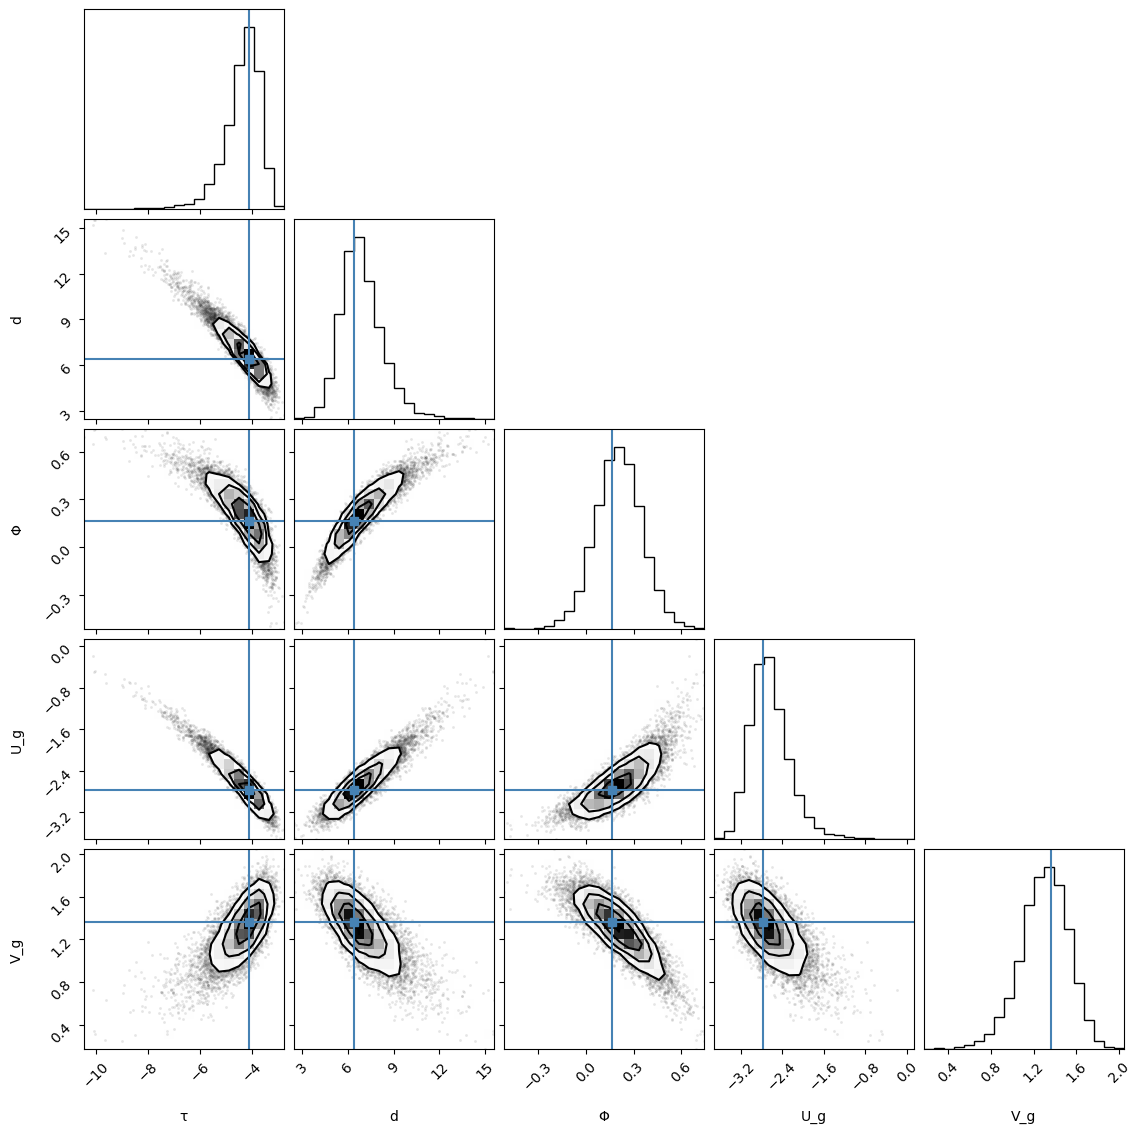

In [81]:
# 🔹 Plot dei risultati con Corner
fig = corner.corner(samples, labels=["τ", "d", "Φ", "U_g", "V_g"], truths=best_fit_params)
plt.show()

# 🔹 Parametri stimati con MCMC
tau_best, d_best, phi_best, U_g_best, V_g_best = np.mean(samples, axis=0)
u_fit, v_fit = ekman_model(z, tau_best, d_best, phi_best, U_g_best, V_g_best)

#### Calcolo del Chi-Quadrato e del Chi-Quadrato Ridotto

Per valutare quanto bene un modello si adatti ai dati osservati si utilizza il test del chi-quadrato (χ²). La formula usata nel codice è:
$$
\chi^2 = \sum \left( \frac{u_{obs} - u_{fit}}{\sigma} \right)^2 + \sum \left( \frac{v_{obs} - v_{fit}}{\sigma} \right)^2
$$
- $u_{obs}$ e $v_{obs}$ sono i dati osservati,
- $u_{fit}$ e $v_{fit}$ sono i valori previsti dal modello,
- $\sigma$ rappresenta l'incertezza o errore associato a ciascuna osservazione.

Questa operazione calcola la somma degli scarti tra valori osservati e stimati, pesati per l'incertezza.
Il chi-quadrato ridotto ($χ²_{rid}$) è ottenuto dividendo il valore del chi-quadrato per il numero di gradi di libertà:
$$
\chi^2_{rid} = \frac{\chi^2}{ndof}
$$

Questa misura permette di valutare la bontà dell'adattamento:
- $\chi^2_{rid} \approx 1$ indica un buon adattamento;
- $\chi^2_{rid} \gg 1$ suggerisce che il modello non descrive bene i dati;
- $\chi^2_{rid} \ll 1$ potrebbe indicare una sovrastima degli errori.

Il valore ottenuto del chi-quadrato ridotto $χ²_{rid} = 8.55$ è significativamente maggiore di 1, il che indica che il modello potrebbe non descrivere bene i dati osservati. Potrebbe essere utile verificare la qualità dell'adattamento del modello, rivedere gli errori associati alle osservazioni (σ) o considerare un modello più complesso.
Alcuni possibili motivi di questo risultato includono:

- Modello troppo semplice: Il modello potrebbe non catturare tutti gli aspetti del fenomeno in esame. Potrebbe essere necessario aggiungere più parametri o considerare una relazione più complessa.
- Errori sottostimati: Se le incertezze  sono troppo piccole, il test del chi-quadrato penalizza eccessivamente le discrepanze tra dati osservati e previsti. Le deviazioni standard associate alle correnti osservate sono dell'ordine di 6-10 m/s, come mostrato dall'output a inizio codice sulle deviazioni standard della corrente (Est) e corrente (Nord). Assumere nel modello un errore di 0,5 m/s è chiaramente una sottostima, portando a un valore di $χ²_{rid}$ eccessivamente alto.
- Outlier nei dati: Valori anomali nei dati osservati possono aumentare significativamente il valore di $χ²_{rid}$ , suggerendo un cattivo adattamento anche se il modello è adeguato. Tra i valori anomali si può considerare il valore di corrente di -11 m/s misurata a 3 metri dalla superficie. 


In [82]:
# Calcolare il chi-quadrato
chi2 = np.sum(((u_obs - u_fit) / sigma) ** 2) + np.sum(((v_obs - v_fit) / sigma) ** 2)

# Numero di gradi di libertà (numero di osservazioni - numero di parametri stimati)
ndof = len(u_obs) - ndim  # Numero di osservazioni meno il numero di parametri stimati

# Calcolare il chi-quadrato ridotto
chi2_rid = chi2 / ndof

# Stampare il chi-quadrato ridotto
print(f"Chi-quadrato: {chi2:.2f}")
print(f"Gradi di libertà: {ndof}")
print(f"Chi-quadrato ridotto: {chi2_rid:.2f}")

Chi-quadrato: 119.59
Gradi di libertà: 14
Chi-quadrato ridotto: 8.54


##### Parametri stimati con MCMC:
I risultati presentati di seguito sono stati ottenuti tramite l'applicazione del metodo MCMC per stimare i parametri del modello, utilizzando i dati osservati delle velocità della corrente. I parametri finali stimati, ottenuti dopo il processo di fitting, sono i seguenti:
- **τ = -5.05 N/m²**: La tensione di superficie (τ) è negativa, il che indica che la direzione della forza superficiale applicata è opposta a quella convenzionale. In un flusso oceanico tipico, la forza superficiale è positiva e segue la direzione del vento, ma quando è negativa può indicare una corrente superficiale che si sviluppa controvento. 
- **d = 6.88 m**: La profondità (d) stimata è di 6.88 metri. Una profondità di 6.88 metri potrebbe indicare la zona in cui la velocità della corrente è stata misurata o in cui si verifica una transizione significativa nel comportamento della corrente, come un cambiamento nella velocità o nella direzione. 
- **Φ = 3.00°**: la corrente superficiale mostra una deviazione di 3° rispetto a alla direzione del vento. Un valore relativamente basso, il che indica che la direzione della corrente è quasi allineata con la superficie orizzontale. Secondo la teoria della Spirale di Ekman la corrente superficiale si orienta in una direzione inclinata rispetto al vento a causa dell'effetto della forza di Coriolis, che agisce perpendicolarmente alla direzione del moto del fluido.
In condizioni ideali, la deviazione teorica della corrente superficiale rispetto al vento dovrebbe essere di circa 45°, ma nel caso specifico osserviamo un valore molto inferiore (solo 3°). 
- **U_g = -2.65 m/s**: La velocità longitudinale della corrente (U_g) è negativa, suggerendo che la componente della corrente in quella direzione si muove verso ovest (se consideriamo la convenzione geografica). Questo potrebbe significare che la corrente sta fluttuando in una direzione opposta rispetto alla normale.
- **V_g = 1.30 m/s**: La componente trasversale della velocità della corrente (V_g) è positiva, indicando che la corrente si sta muovendo verso nord (secondo la convenzione geografica). Questo valore è relativamente basso rispetto alla componente longitudinale, indicando una componente di movimento laterale più contenuta.

Le velocità osservate e quelle teoriche vengono confrontate per diverse profondità in metri. La tabella mostra la velocità della corrente nei due componenti orizzontali:
- 𝑢 (componente Est-Ovest)
- 𝑣 (componente Nord-Sud)

confrontando i valori osservati (𝑢_obs, 𝑣_obs) con quelli stimati dal modello (𝑢_fit, 𝑣_fit).

Il componente 𝑣 diminuisce progressivamente con la profondità, indicando un’influenza della forza di Coriolis, come previsto dalla teoria di Ekman.
Il componente 𝑢 mostra un comportamento più complesso, con discrepanze maggiori tra il modello e i dati osservati vicino alla superficie.
Il modello segue bene l'andamento generale della corrente oceanica, specialmente in profondità maggiori.
Per profondità superiori a -10 m, ci sono discrepanze più visibili tra i valori osservati e quelli stimati, in particolare per il componente 
𝑢. A 2 m di profondità, il valore osservato di 𝑢_obs è -11.92 m/s, mentre il modello prevede -8.14 m/s. Questa differenza è piuttosto marcata, suggerendo che il modello potrebbe sottostimare l’intensità della corrente superficiale.
Anche il componente 𝑣 mostra differenze in superficie, con 𝑣_obs = −3.157 m/s rispetto a 𝑣_fit = −1.755 m/s.

##### Interpretazione delle discrepanze

- Effetti locali non catturati dal modello: 
Le differenze più grandi in superficie possono essere dovute a fattori non inclusi nel modello teorico, come variazioni temporali del vento, effetti di turbolenza, stratificazione verticale e interazioni con altre correnti oceaniche.

- Possibile sottostima dell’intensità della corrente superficiale e dell'errore associato 
Il modello sembra sottovalutare la componente Est-Ovest (𝑢) e il suo errore associato in superficie, il che potrebbe indicare che la scala di profondità di Ekman stimata non è perfettamente ottimizzata o che il coefficiente di viscosità adottato non cattura tutta la dinamica del flusso. Un errore sottostimato potrebbe anche significare che il modello non riflette adeguatamente la complessità del flusso oceanico, che potrebbe essere molto più variabile o caotico di quanto supposto. Poichè i dati osservativi sono molto più rumorosi di quanto previsto (con errori reali di 6-10 m/s), il modello, che assume un errore di 0,5 m/s, non riusce a tracciare correttamente le dinamiche della corrente, portando a soluzioni imprecise, in particolare nella componente Est-Ovest, che potrebbe essere più sensibile a fluttuazioni locali.

- Buona corrispondenza in profondità
Per profondità maggiori di 10-15 m, il modello e le osservazioni sono in buona concordanza, indicando che il modello cattura bene il comportamento della corrente Ekman più in profondità, dove gli effetti turbolenti e non lineari sono meno rilevanti.


In [83]:
# 🔹 Stampare i parametri finali
print(f"Parametri stimati con MCMC:")
print(f"τ  = {tau_best:.2f} N/m²")
print(f"d  = {d_best:.2f} m")
print(f"Φ  = {np.degrees(phi_best):.2f}°")
print(f"U_g = {U_g_best:.2f} m/s")
print(f"V_g = {V_g_best:.2f} m/s")

# 🔹 Stampare le velocità osservate e teoriche della corrente
print("\nProfondità (m) |  u_obs (m/s)  |  u_fit (m/s)  |  v_obs (m/s)  |  v_fit (m/s)")
print("-" * 65)
for i in range(len(z)):
    print(f"{z[i]:>10.1f} | {u_obs[i]:>12.3f} | {u_fit[i]:>12.3f} | {v_obs[i]:>12.3f} | {v_fit[i]:>12.3f}")

Parametri stimati con MCMC:
τ  = -4.38 N/m²
d  = 6.93 m
Φ  = 11.78°
U_g = -2.64 m/s
V_g = 1.30 m/s

Profondità (m) |  u_obs (m/s)  |  u_fit (m/s)  |  v_obs (m/s)  |  v_fit (m/s)
-----------------------------------------------------------------
     -20.0 |       -2.554 |       -2.401 |        2.500 |        1.705
     -19.0 |       -2.246 |       -2.435 |        2.758 |        1.802
     -18.0 |       -2.772 |       -2.490 |        2.317 |        1.907
     -17.0 |       -2.826 |       -2.569 |        2.483 |        2.018
     -16.0 |       -3.090 |       -2.679 |        2.987 |        2.131
     -15.0 |       -3.226 |       -2.823 |        2.401 |        2.243
     -14.0 |       -3.483 |       -3.007 |        2.229 |        2.347
     -13.0 |       -3.338 |       -3.234 |        1.999 |        2.435
     -12.0 |       -3.710 |       -3.508 |        1.783 |        2.498
     -11.0 |       -3.443 |       -3.831 |        2.484 |        2.524
     -10.0 |       -4.220 |       -4.206 |    

#### Analisi delle catene MCMC per il modello di Ekman

L'analisi delle catene MCMC (Markov Chain Monte Carlo) è stata condotta per verificare la convergenza e il comportamento stocastico delle simulazioni. Il codice riportato estrae le catene MCMC generate dal campionatore e le visualizza per ciascun parametro del modello di Ekman.
Le catene vengono estratte utilizzando il metodo sampler.get_chain(), che restituisce un array contenente le traiettorie di ogni parametro campionato nel processo MCMC. Ogni colonna dell'array rappresenta l'evoluzione temporale di un parametro specifico durante le iterazioni del campionamento.

Le traiettorie dei parametri vengono plottate per analizzarne il comportamento nel tempo. I parametri analizzati includono:

- $\tau$: Stress del vento
- $d$: Profondità di Ekman
- $\Phi$: Angolo di deflessione
- $U_g$: Componente longitudinale della velocità geostrofica
- $V_g$: Componente trasversale della velocità geostrofica

Il codice genera un grafico con un sottografico per ciascun parametro, permettendo di esaminare la variazione delle catene lungo gli step del campionamento.
Dal grafico ottenuto, si osserva che le catene presentano un buon mescolamento e non mostrano derive evidenti o transizioni marcate, suggerendo che il campionamento ha raggiunto la convergenza. Questo comportamento è un segnale positivo, in quanto suggerisce che le catene esplorano in maniera efficace lo spazio dei parametri senza rimanere intrappolate in regioni locali.
Le catene appaiono fluttuare attorno a valori medi ben definiti dopo un certo numero di iterazioni, suggerendo che è stata raggiunta una fase di stazionarietà, ovvero le catene non mostrano una tendenza a crescere o decrescere sistematicamente.

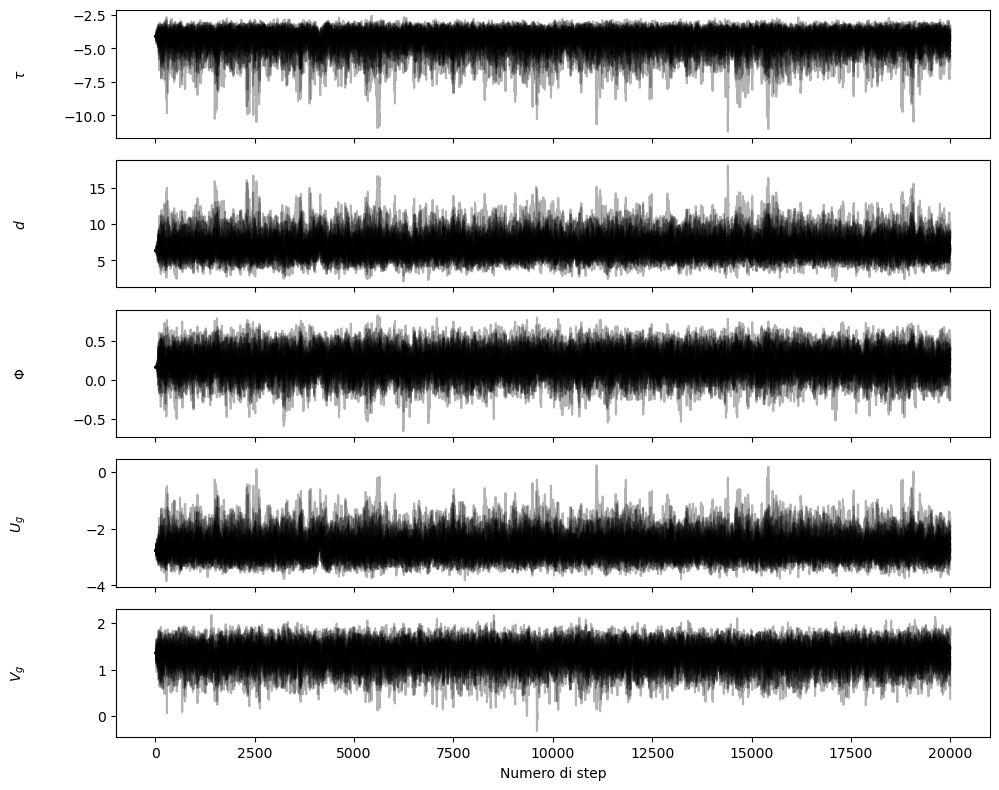

In [84]:
# Estrai le catene MCMC
tau_chain = sampler.get_chain()

# Etichette dei parametri
labels = ["$\\tau$", "$d$", "$\\Phi$", "$U_g$", "$V_g$"]
fig, axes = plt.subplots(ndim, figsize=(10, 8), sharex=True)

# Plotta le catene per ogni parametro
for i in range(ndim):
    ax = axes[i]
    ax.plot(tau_chain[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Numero di step")
plt.tight_layout()
plt.show()


##### Analisi delle Correnti Osservate vs Modello
Per analizzare il comportamento delle correnti oceaniche, è stato generato un grafico che confronta i dati osservati con il modello teorico di Ekman. In ascissa è stata rappresentata la componente della corrente orientata verso Est (u), mentre in ordinata (asse y)  la componente della corrente orientata verso Nord (v), tutto in funzione della profondità (dal fondale).

Osservando il grafico, si nota che:

- Struttura a spirale: La distribuzione delle correnti mostra una rotazione della direzione della corrente con l'aumentare della profondità, in accordo con la teoria di Ekman.

- Accordo tra modello e dati: Il modello teorico segue qualitativamente l'andamento dei dati osservati, ma ci sono alcune discrepanze.

- Punti anomali a bassa profondità: Alcuni punti a profondità minori, come a 2 metri dalla superficie, presentano deviazioni significative rispetto alla previsione del modello di Ekman e non seguono l'andamento teorico atteso. Ad esempio, il valore osservato della corrente a -2m è significativamente più intenso rispetto al modello (-11.92 m/s contro -8.143 m/s per la componente Est e -3.157 m/s contro -1.755 m/s per la componente Nord). Questo potrebbe essere dovuto a fenomeni di mescolamento turbolento, presenza di stratificazioni instabili o errori strumentali nelle misurazioni. Queste variazioni marcate e apparentemente non coerenti con il modello potrebbero essere dovute all'influenza diretta del vento sulla superficie dell'acqua, alla presenza di onde e processi non inclusi nella teoria classica di Ekman. Ad esempio, a -4m si osserva un valore della corrente Est di -6.788 m/s, mentre il modello predice un valore di -7.732 m/s, evidenziando una discrepanza non trascurabile.

- Oscillazioni nelle misure: Le oscillazioni osservate nelle velocità delle correnti potrebbero essere dovute a fenomeni locali non considerati nel modello, come gradienti di temperatura o correnti esterne che variano l'intensità in base alla profondità. Il modello di Ekman assume infatti che l'intensità della corrente sia costante per ogni altezza, il che potrebbe non essere realistico in ambienti caratterizzati da variazioni termiche o dinamiche più complesse.

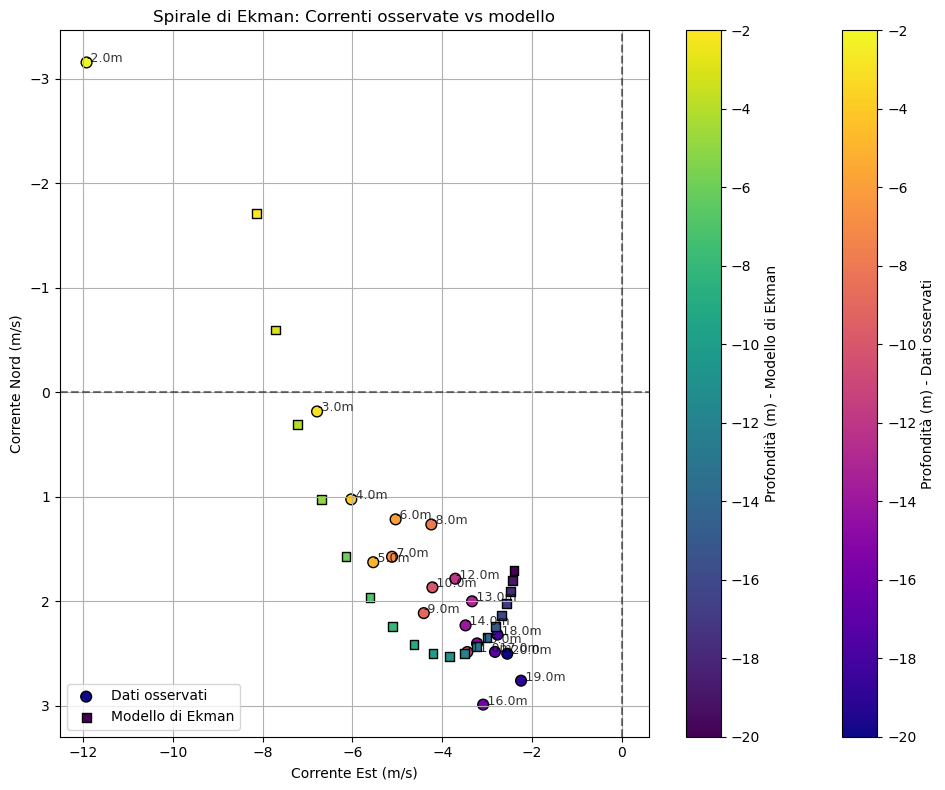

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Creazione della figura con due colonne per le color bar
fig, ax = plt.subplots(figsize=(10, 8))

# Mappa colori basata sulla profondità
cmap_obs = plt.cm.plasma  # Colormap per i dati osservati
cmap_fit = plt.cm.viridis  # Colormap per il modello di Ekman
norm = plt.Normalize(min(z), max(z))  # Normalizzazione per color bar

# Scatter plot con colori
scatter1 = ax.scatter(u_obs, v_obs, c=z, cmap=cmap_obs, edgecolors="k", s=60, label="Dati osservati")
scatter2 = ax.scatter(u_fit, v_fit, c=z, cmap=cmap_fit, edgecolors="k", s=40, marker="s", label="Modello di Ekman")

# Annotazioni della profondità
for i in range(len(z)):
    ax.annotate(f"{z[i]}m", (u_obs[i], v_obs[i]), fontsize=9, color="black", alpha=0.8)

# Aggiungere color bar per la profondità
cbar1 = plt.colorbar(scatter1, ax=ax)
cbar1.set_label("Profondità (m) - Dati osservati")
cbar2 = plt.colorbar(scatter2, ax=ax)
cbar2.set_label("Profondità (m) - Modello di Ekman")

# Impostazioni del grafico
ax.set_xlabel("Corrente Est (m/s)")
ax.set_ylabel("Corrente Nord (m/s)")
ax.set_title("Spirale di Ekman: Correnti osservate vs modello")
ax.axhline(0, color="k", linestyle="--", alpha=0.5)  # Linea asse orizzontale
ax.axvline(0, color="k", linestyle="--", alpha=0.5)  # Linea asse verticale
ax.invert_yaxis()
ax.legend()
ax.grid()

# Mostrare il grafico
plt.tight_layout()  # Ottimizza lo spazio per le color bar affiancate
plt.show()


##### Visualizzazione del grafico 3D del modello con emcee
La figura rappresenta la Spirale di Ekman con l'intensità delle correnti oceanografiche in funzione della profondità. Gli elementi chiave sono i seguenti:

- Spirale di Ekman (linea tratteggiata rossa): rappresenta la traiettoria delle correnti con la profondità, dove la velocità diminuisce con la profondità e cambia direzione progressivamente.
- Frecce colorate lungo la spirale: indicano la direzione e l’intensità del flusso. Il colore varia con la profondità secondo la colormap viridis (dal blu al giallo).
- Frecce rosse partenti dall'origine (0,0): rappresentano il vettore velocità della corrente a ogni profondità. La loro lunghezza è proporzionale alla velocità della corrente.
- Proiezione della spirale nel piano XY : Tracciata in nero trasparente per evidenziare la traiettoria senza la componente verticale.
- L’asse Z rappresenta la profondità (da -2 a -20 m dal fondale).
- Gli assi X e Y indicano le componenti della velocità della corrente.

##### Confronto con il modello teorico e l'algoritmo di ottimizzazione

Rispetto al caso senza l'uso dell'algoritmo emcee, questa rappresentazione segue ancora più fedelmente le previsioni del modello di Ekman. L'ottimizzazione bayesiana dei parametri ha consentito di migliorare la stima dei coefficienti del modello, riducendo l'incertezza nelle misurazioni e minimizzando gli errori di fitting.

Grazie all'uso di emcee, l'adattamento dei dati osservati alla teoria è più preciso e la struttura della spirale è più accentuata, con una progressione della rotazione e della diminuzione della velocità che ricalca con maggiore fedeltà la soluzione analitica del modello. Questo conferma la validità del metodo di stima adottato e rafforza l’affidabilità del modello di Ekman nel descrivere il comportamento delle correnti oceaniche osservate.

Anche se la corrente superficiale è deviata di soli 3° rispetto al vento, con l’aumento della profondità la rotazione della corrente continua, mostrando un andamento a spirale, coerente con la teoria di Ekman.
La direzione della corrente ruota progressivamente in senso orario (nell'emisfero nord), fino a raggiungere quasi 90°–180° di deviazione a profondità maggiori.
Questo conferma che il modello descrive correttamente il comportamento della colonna d’acqua, anche se con una deviazione iniziale inferiore alle aspettative.


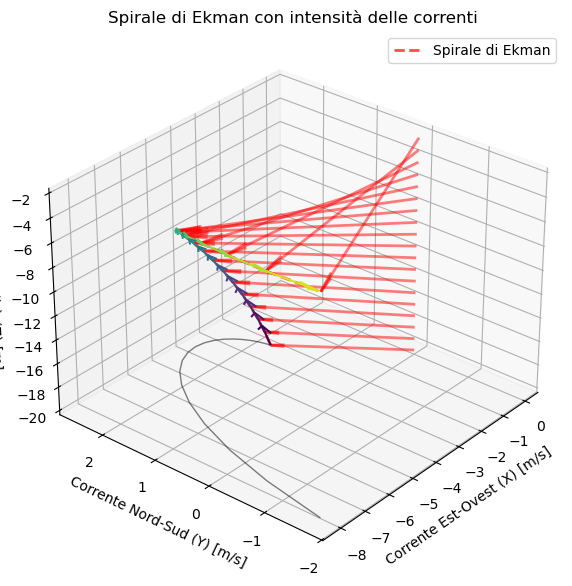

In [86]:
# Normalizzazione dei valori di profondità per applicare una mappa di colori
# La normalizzazione serve a scalare i valori di profondità tra il minimo e il massimo per ottenere una rappresentazione visiva coerente
norm = colors.Normalize(vmin=np.min(profondita), vmax=np.max(profondita))  # Normalizza la profondità
cmap = cm.viridis  # Colormap 'viridis' per colorare la spirale da viola (basso) a giallo (alto)
colors_array = cmap(norm(profondita))  # Applica la colormap ai dati di profondità

# Creazione della figura per il grafico 3D
fig = plt.figure(figsize=(10, 7))  # Impostiamo le dimensioni della figura
ax = fig.add_subplot(111, projection='3d')  # Creiamo un grafico 3D

# **Tracciamento della Spirale di Ekman**
# La spirale è tracciata come una linea tratteggiata rossa (r--) che rappresenta la traiettoria delle correnti in funzione della profondità
ax.plot(u_fit, v_fit, profondita, 'r--', alpha=0.7, linewidth=2, label="Spirale di Ekman")

# **Aggiunta delle frecce lungo la spirale per indicare la direzione del flusso**
step = 1  # Intervallo tra le frecce
# Le frecce sono tracciate lungo la spirale. 'np.diff' calcola la differenza tra i punti consecutivi
# in modo da determinare la direzione e l'intensità del flusso tra ogni punto della spirale
ax.quiver(
    u_fit[::step], v_fit[::step], profondita[::step],  # Coordinate di partenza delle frecce
    np.diff(u_fit, append=u_fit[-1])[::step],  # Variazione in u (direzione Est-Ovest)
    np.diff(v_fit, append=v_fit[-1])[::step],  # Variazione in v (direzione Nord-Sud)
    np.diff(profondita, append=profondita[-1])[::step],  # Variazione in profondità
    color=colors_array[::step],  # Colore delle frecce in base alla profondità
    length=1.5,  # Lunghezza delle frecce
    normalize=True  # Normalizzazione delle frecce per renderle visivamente uniformi
)

# **Aggiunta delle frecce per rappresentare l'intensità delle correnti**
# Ogni freccia rappresenta l'intensità della corrente e viene disegnata dal punto di origine (0, 0, profondita[i])
# La lunghezza della freccia è proporzionale alla velocità della corrente (modulo del vettore velocità)
for i in range(len(profondita)):
    velocita_corrente = np.sqrt(u_fit[i]**2 + v_fit[i]**2)  # Calcolo del modulo della velocità corrente
    ax.quiver(
        0, 0, profondita[i],  # Origine della freccia (all'origine X=0, Y=0)
        u_fit[i], v_fit[i], 0,  # Componente della velocità nelle direzioni X e Y
        color='r', alpha=0.5, linewidth=2, arrow_length_ratio=0.1  # Freccia rossa, con trasparenza e rapporto di lunghezza dell'arco
    )

# **Proiezione della spirale nel piano XY**
# Aggiungiamo una proiezione della spirale nel piano orizzontale (piano XY) per osservare la traiettoria
# della spirale senza considerare la profondità. Questa proiezione è disegnata in nero con trasparenza.
ax.plot(u_fit, v_fit, np.full_like(profondita, profondita.min()), 'k-', alpha=0.5, linewidth=1)

# **Impostazioni degli assi e della visualizzazione**
ax.set_xlabel("Corrente Est-Ovest (X) [m/s]")  # Etichetta dell'asse X per le velocità Est-Ovest
ax.set_ylabel("Corrente Nord-Sud (Y) [m/s]")  # Etichetta dell'asse Y per le velocità Nord-Sud
ax.set_zlabel("Profondità (Z) [m]")  # Etichetta dell'asse Z per la profondità
ax.set_title("Spirale di Ekman con intensità delle correnti")  # Titolo del grafico

# **Angolazione ottimale per la vista 3D**
# Impostiamo l'angolo di elevazione (30 gradi) e di azimut (220 gradi) per visualizzare bene sia la spirale
# che le frecce di intensità, in modo che la visualizzazione sia chiara.
ax.view_init(elev=30, azim=220)

# **Aggiunta della legenda**
# La legenda descrive il significato della spirale di Ekman nel grafico, per aiutare nella comprensione visiva
plt.legend()

# **Mostriamo il grafico**
plt.show()  # Mostriamo il grafico risultante

##### Visualizzazione grafico 3D per i dati osservati
Il grafico risultante è una visualizzazione 3D della spirale di Ekman con frecce che indicano la direzione e l'intensità delle correnti. La profondità è rappresentata tramite il colormap viridis, e la barra dei colori fornisce una legenda visiva per interpretare la profondità. L'aggiunta di frecce rosse evidenzia l'intensità delle correnti lungo la spirale.
A differenza del caso teorico, dove la corrente segue un’evidente struttura a spirale, qui l’andamento è più irregolare, indicando la presenza di fenomeni non catturati dal modello ideale di Ekman. Nei dati osservati, la rotazione della corrente con la profondità è meno regolare rispetto alla previsione teorica. Questo può essere dovuto a effetti locali come turbolenza, variazioni di stratificazione e interferenze con altre correnti. Dall'altra parte le frecce rosse, che rappresentano la velocità della corrente, aumentano di intensità avvicinandosi alla superficie, come previsto dalla teoria di Ekman. Questo comportamento è atteso perché la corrente superficiale è direttamente forzata dal vento, mentre a profondità maggiori l’energia cinetica si dissipa per attrito. Nonostante la mancanza di una perfetta spirale, si nota comunque una progressiva deviazione della corrente con la profondità, suggerendo che l'effetto Ekman sia ancora presente, sebbene perturbato da altri fattori.
La rotazione segue la tendenza oraria prevista nell’emisfero nord, anche se con deviazioni locali.

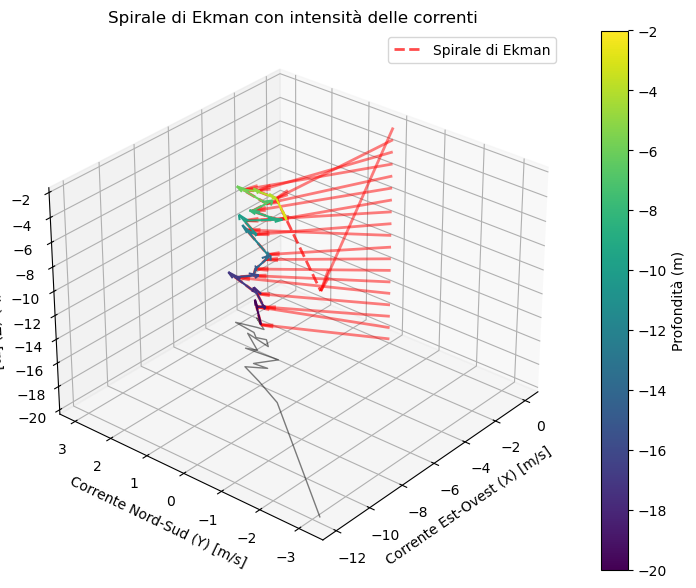

In [87]:
# Normalizzazione della profondità per mappare i colori in modo appropriato
norm = colors.Normalize(vmin=np.min(z), vmax=np.max(z))
cmap = cm.viridis  # Colormap 'viridis' che varia dal viola al giallo
colors_array = cmap(norm(z))  # Assegna un colore per ogni valore di profondità

# Creazione della figura e dell'asse 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# **Tracciamento della Spirale di Ekman**
# La spirale è tracciata come una linea tratteggiata rossa lungo le componenti u, v e la profondità z
ax.plot(u_obs, v_obs, z, 'r--', alpha=0.7, linewidth=2, label="Spirale di Ekman")

# **Aggiunta delle frecce lungo la spirale per rappresentare la direzione del flusso**
# Utilizziamo 'np.diff' per ottenere la variazione tra i punti adiacenti
step = 1  # Intervallo tra le frecce
ax.quiver(
    u_obs[::step], v_obs[::step], z[::step],  # Posizione iniziale delle frecce
    np.diff(u_obs, append=u_obs[-1])[::step],  # Variazione in u
    np.diff(v_obs, append=v_obs[-1])[::step],  # Variazione in v
    np.diff(z, append=z[-1])[::step],  # Variazione in z (profondità)
    color=colors_array[::step],  # Colore delle frecce in base alla profondità
    length=1.5,  # Lunghezza delle frecce
    normalize=True  # Normalizza le frecce per una visualizzazione uniforme
)

# **Aggiunta delle frecce che rappresentano l'intensità della corrente**
# Per ogni profondità, calcoliamo la velocità della corrente (modulo del vettore velocità)
for i in range(len(z)):
    velocita_corrente = np.sqrt(u_obs[i]**2 + v_obs[i]**2)  # Modulo del vettore velocità
    ax.quiver(
        0, 0, z[i],  # Posizione di origine per ogni freccia (all'origine X=0, Y=0)
        u_obs[i], v_obs[i], 0,  # Componente della velocità nella direzione X e Y
        color='r', alpha=0.5, linewidth=2, arrow_length_ratio=0.1  # Frecce rosse con trasparenza
    )

# **Proiezione della spirale nel piano XY**
# Aggiungiamo una proiezione della spirale sul piano orizzontale per visualizzare la sua evoluzione senza la profondità
ax.plot(u_obs, v_obs, np.full_like(z, z.min()), 'k-', alpha=0.5, linewidth=1)

# **Impostazioni degli assi e della visualizzazione**
ax.set_xlabel("Corrente Est-Ovest (X) [m/s]")  # Etichetta per l'asse X
ax.set_ylabel("Corrente Nord-Sud (Y) [m/s]")  # Etichetta per l'asse Y
ax.set_zlabel("Profondità (Z) [m]")  # Etichetta per l'asse Z
ax.set_title("Spirale di Ekman con intensità delle correnti")  # Titolo del grafico

# Migliorare la visualizzazione della vista 3D
ax.view_init(elev=30, azim=220)  # Angolazione della vista per una visualizzazione ottimale

# **Aggiunta di una barra dei colori per rappresentare la profondità**
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)  # Mappa colori scalare
sm.set_array([])  # Dobbiamo impostare array vuoto per il colormap
fig.colorbar(sm, ax=ax, label="Profondità (m)")  # Aggiunta della barra dei colori

# **Visualizzazione della legenda**
plt.legend()

# Mostriamo il grafico
plt.show()


##### Conclusioni

Il confronto tra dati osservati e modello teorico suggerisce che la spirale di Ekman non rappresenta adeguatamente il comportamento generale delle correnti oceaniche in funzione della profondità. Infatti, a causa della sottostima dell'erroe associato alle misure, il fitting dei parametri risulta essere distorto. Questo porterebbe a una rappresentazione inaccurata della spirale di Ekman e delle sue caratteristiche, come la profondità di penetrazione e l'angolo di deviazione. Quindi, più che dire che il modello "non funziona", si può affermare che il suo adattamento ai dati osservati è limitato dalla sottostima dell'errore, suggerendo che una modellazione più accurata dovrebbe tener conto di questa maggiore incertezza.
Dall'altra parte le discrepanze indicano la necessità di considerare modelli più avanzati che incorporino effetti turbolenti e variazioni spaziali della viscosità. 